**import packages used**

In [1]:
import numpy as np
import random
from pyXRD import pyXRDCodes
from scipy.signal import find_peaks
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Corrected

In [11]:
#============MOD CROSSOVER===========
class Structure:
    def __init__(self, atoms, positions,symmetry, unit_params,unit_angles,
                theta,hkls,counts,step = 0.01,group_sym=[194]):
        """
        Initialize a Structure with given parameters.
        
        Args:
            atoms: List of atom types in this Structure.
            positions: List of each atom position. An array with shape (N,n), N being the number of atom types and n number of atoms  giving the atom type.
            symmetry: The symmetry group number. 
            unit_params: List of lattice parameters [a, b, c] (should be nummpy array)
            unit_angles: List of lattice angles [α, β, γ] in degrees (should be nummpy array)
            theta: List of Peak angles alredy defined by unit cell.
            hkls: List of hkls planes already defined by unit cell.
            counts: Multiplicity factor already defined by unit cell.
            step: The size of the smallest diference between two points in space.
            group_sym: All possible symmetry group numbers the Structure could change into. 
        """
        # Validate inputs
        if len(unit_params) != 3 or len(unit_angles) != 3:
            raise ValueError("Both unit_params and unit_angles must have length 3")
        # Later add more of those giving the formatation of the 'positions' array.

        self.atoms = atoms  # List of atom types (e.g., ['Ti', 'C'])
        self.positions = positions  # List of positions for each atom type
        self.unit_params = unit_params
        self.unit_angles = unit_angles
        self.symnumb = symmetry
        self.symmetry = pyXRDCodes.get_symmetry_operations_number(symmetry)
        self.thetas = theta
        self.hkls = hkls
        self.counts = counts
        self.param_grid = np.arange(0,1,step)
        self.param_step = step
        self.group_sym = group_sym

        # Do to make it a possible configuration
        self.separate_overlapping_atoms(min_distance=0.1, target_distance=0.25, max_iterations=100)


    def calculate_xrd(self, lamb):
        """Calculates the XRD pattern based on the structure's parameters.

        Args:
            lamb: wavelenght of the source.
        Returns:
            The XRD intensity pattern.
        """
        pos = self.positions
        primit,unit_pos,_ = pyXRDCodes.find_atoms_unit_cell(pos, self.unit_params, self.unit_angles, self.symmetry)   
        #primit,unit_pos = self.get_primit_unit()

        data = pyXRDCodes.Intensid_xrd(
            lamb,self.hkls,self.thetas,self.counts,
            self.unit_params,
            self.unit_angles,
            primit,
            self.atoms)

        theta2 = np.array(data['two_thetas'])
        intensities = np.array(data['intensities'])
        if len(intensities) == 0:
            return np.array([0]),np.array([0])
        
        intensities = intensities / np.max(intensities)

        return theta2,intensities

    def mutate(self,  add_prob=0.05,take_prob=0.05,change_prob = 0.1 ,shuffle_prob = 0.05 ,
               change_atom = 0.05,max_shift =35 ,max_atoms_per_atom=3,change_prob_sym=0.1,
                 only_alter_pos=False,preserve_atoms = True,fix_numb_atoms=False):
        """
        Mutates the wyckoff positions by randomly changing atom types and slightly perturbing atomic positions. 
        The atoms and positions are flattened and shuffled.
        
        Args:
            add_prob: The probability a new atom will be added in the system.
            take_prob: The probability an atom will be removed from the structure ( where we can ensure that we maintain one of each).
            change_prob: The probability to move one of the present atoms.
            shuffle_prob: The probability to shuffle the x,y and z prosition of the atom.
            change_atom: The probability to change one atom's atom type.
            max_shift: The biggest step one atom can take when changing its position.
            max_atoms_per_atom: The limit number of atoms any atom kind can have.
            change_prob_sym: The probability to change the symmetry of the structure.
            only_alter_pos: If True we have the mutation only altering an atom's atom type.
            preserve_atoms: If True we must have at least one of each atom type.
            fix_numb_atoms: If True we maintain the total number of atoms.
            ...
            (More modes can be implemented until here I just added the ones I desired to work with)
        """

        # Flatten atoms and positions into one list
        flat_positions,verif_pos = self.flat_positions(self.atoms.copy(),self.positions.copy(),max_shift=0.00)
        # Count original atom types (optional: to preserve at least one)
        atom_counts = {}
        # Count atom types in flat_positions
        for atom, _ in flat_positions:
            atom_type = str(atom)  # Convert to string if not already
            if atom_type in atom_counts:
                atom_counts[atom_type] += 1
            else:
                atom_counts[atom_type] = 1

        if only_alter_pos:
            for i, (atom, pos) in enumerate(flat_positions):
                # Change atom type with probability
                if random.random() < change_atom:
                    # Make a list with all other atoms
                    possible_atoms = [a for a in self.atoms if a != atom]
                    if possible_atoms:
                        if atom_counts[atom] <= 1:
                            pass  # don't allow change if only one left
                        else:
                            new_atom = random.choice(possible_atoms)
                            flat_positions[i] = (new_atom, pos)
                            atom_counts[atom] -= 1
                            atom_counts[new_atom] += 1

        else:
            i=0
            new_flat = []
            if fix_numb_atoms:               
                for atom, pos in flat_positions:
                    new_pos = pos.copy()
                    new_atom = atom         
                    # Position movement
                    if random.random()<change_prob:
                        shift = np.random.randint(-max_shift, max_shift+1, size=3)
                        new_pos = list(np.round(abs(new_pos + shift*self.param_step) % 1,2))  # Wrap around unit cell
                    # Position shuffle
                    if random.random() < shuffle_prob:
                        new_pos = list(random.sample(new_pos, 3))
                    #Change the position of two atoms
                    if random.random() <change_atom:
                        idxs = np.arange(0,len(flat_positions),1)
                        possib_new_atom = random.choice(idxs[idxs!=i])
                        n_pos = flat_positions[possib_new_atom][1].copy()
                        flat_positions[possib_new_atom] = (flat_positions[possib_new_atom][0],new_pos.copy())
                        new_pos = n_pos
                        
                    new_flat.append((new_atom, new_pos ))
                    i+=1

                    if (random.random() <change_prob_sym)&(len(self.group_sym)>1):
                        self.symnumb = random.choice(self.group_sym[self.group_sym!=self.symnumb])
                        self.symmetry = pyXRDCodes.get_symmetry_operations_number(self.symnumb)
            else:
                for atom, pos in flat_positions:
                    new_pos = np.array(pos).copy()          
                    # Position movement
                    if random.random()<change_prob:
                        shift = np.random.randint(-max_shift, max_shift+1, size=3)
                        new_pos = abs(new_pos + shift*self.param_step) % 1  # Wrap around unit cell
                    else:
                        # Position shuffle
                        if random.random() < shuffle_prob:
                            new_pos = random.sample(list(new_pos), 3)
                        
                    # Atom type change
                    if random.random() < change_atom and (not preserve_atoms or atom_counts[atom] > 1):
                        new_atom = random.choice(self.atoms)
                        if atom_counts[new_atom] < max_atoms_per_atom:
                            atom_counts[atom] -= 1
                            atom_counts[new_atom] += 1
                            atom = new_atom

                    new_flat.append((atom, list(new_pos).copy()))

                flat_positions = new_flat.copy()
                
                # Add/remove atoms
                new_flat = []
                for atom, pos in flat_positions:
                    # Remove atom with probability
                    if random.random() < take_prob and (not preserve_atoms or atom_counts[atom] > 1):
                        atom_counts[atom] -= 1
                        continue
                    
                    new_flat.append((atom, pos))
                    
                    # Add similar atom with probability
                    if random.random() < add_prob and atom_counts[atom]<max_atoms_per_atom:
                        new_pos = np.round(abs(np.array(pos).copy() + np.random.randint(-max_shift, max_shift+1, 3)*self.param_step)%1 , 2) #+np.random.uniform(-0.01, 0.01, 3) ) % 1
                        new_flat.append((atom, list(new_pos)))
                        verif_pos.append(new_pos)
                        atom_counts[atom] += 1
                
                flat_positions = new_flat.copy()
                if (random.random() <change_prob_sym)&( len(self.group_sym)>1):
                    self.symnumb = random.choice(self.group_sym[self.group_sym!=self.symnumb])
                    self.symmetry = pyXRDCodes.get_symmetry_operations_number(self.symnumb)
        
        # Rebuild grouped structure
        atomss ,poss = self.unflatten_positions(flat_positions.copy())
        self.atoms = atomss.copy()
        self.positions = poss.copy()
       
            
        self.separate_overlapping_atoms(min_distance=0.1, target_distance=0.25, max_iterations=100)
        
    def crossover(self, other, inherit_prob=0.5, max_atoms_per_atom=3,
                   preserve_atoms=True, fix_numb_atoms = True):
        """
        Performs crossover where child can inherit atoms from either parent based on probability.
        
        Args:
            other (Structure): The other parent structure.
            inherit_prob: Probability of taking an atom from self (parent 1).
            max_atoms_per_atom:The limit number of atoms any atom kind can have.
            preserve_atoms: If True, ensures at least one of each atom type remains.
            fix_numb_atoms: If True, we maintain the total number of atoms.
            ...
            (I did not add the mode where we only vary the atom kind, because the fix_numb_atoms should do something similar...)
            (More modes can be added soon...)
            
        Returns:
            Structure: The child structure.
        """
        # Make child be this Structure
        child = self.copy()
        
        # Flatten positions of both parents and shuffle so that we vary everything
        flat_self, _ = self.flat_positions(self.atoms.copy(), self.positions.copy(), max_shift=0.00)
        flat_self = random.sample(flat_self, len(flat_self))
        flat_other, _ = self.flat_positions(other.atoms.copy(), other.positions.copy(), max_shift=0.00)
        flat_other = random.sample(flat_other, len(flat_other))
        
        # Combine all unique atom types from both parents
        all_atoms = list(set(self.atoms) | set(other.atoms))
        
        # For each atom type, decide which parent to inherit from
        combined = []
        atom_counts = {atom: 0 for atom in all_atoms}
        
        if fix_numb_atoms:
            # Process each atom type separately
            for atom,pos in flat_self:
                new_pos = pos.copy()
                S=True
                for other_atom,other_pos in flat_other:
                    if atom == other_atom:
                        if random.random() < inherit_prob and S:
                            new_pos = other_pos.copy()
                            flat_other.remove( (other_atom,other_pos)) # Ensure that we don't end up with duplicate atoms.
                            S=False

                combined.append( (atom, list( np.round(abs(np.array(new_pos )),2) ) ) )
        else:
            for atom in all_atoms:
                # Get positions from both parents for this atom type
                self_positions = [(a, p) for a, p in flat_self if a == atom]
                other_positions = [(a, p) for a, p in flat_other if a == atom]
                
                # Decide which parent to take this atom from
                if random.random() < inherit_prob:
                    # Take from self (parent 1)
                    positions_to_add = self_positions
                else:
                    # Take from other (parent 2)
                    positions_to_add = other_positions
                    
                # Adding each of the 'positions_to_add' while respecting 'max_atoms_per_atom'
                for a, pos in positions_to_add:
                    if atom_counts[atom] < max_atoms_per_atom:
                        combined.append((a, list(abs(np.array(pos) + np.random.randint(-5,5,3)*self.param_step)%1)))
                        atom_counts[atom] += 1
                        
                # Ensure we preserve at least one of each atom if requested
                if preserve_atoms and atom_counts[atom] == 0:
                    # Take one from whichever parent has it
                    if self_positions:
                        combined.append(self_positions[0])
                        atom_counts[atom] += 1
                    elif other_positions:
                        combined.append(other_positions[0])
                        atom_counts[atom] += 1
        

        
        # Rebuild atom and position lists
        atoms_new, pos_new = self.unflatten_positions(combined)
        child.atoms = atoms_new
        child.positions = pos_new
        
        child.separate_overlapping_atoms(min_distance=0.1, target_distance=0.25, max_iterations=100)
        # Randomly inherit symmetry from either parent
        if random.random() > inherit_prob:
            child.symnumb = other.symnumb
            child.symmetry = other.symmetry
        
        return child
    
    # =====
    # HELPER Functions
    # =====

    def copy(self):
        """
        Function that creates a copy  of this structure.
        """
        return Structure(self.atoms.copy(), self.positions.copy(),self.symnumb, self.unit_params.copy(),self.unit_angles.copy(),
                         self.thetas.copy(),self.hkls.copy(),self.counts.copy(),self.param_step,self.group_sym)
    
    def flat_positions(self,ATOMS,POS,max_shift=0):
        """
        Function that alter the array of positions is formatation.

        Args:
            ATOMS: The Atom types list.
            POS: The Positions of atoms list, as used in the pyXRD package.
            max_shift: Max small variation we can add in each positions.

        Returns:
            flat_positions: New array with (atom type, position) as each element.
            verif_pos: Array with only the positions for each atom.
        """
        flat_positions = []
        verif_pos = []
        for atom, pos_list in zip(ATOMS, POS):
            for pos in pos_list:
                flat_positions.append((atom, list(np.round(abs(np.array(pos).copy() + np.random.randint(-max_shift, max_shift + 1, size=3)) % 1,2)) ))
                verif_pos.append(flat_positions[-1][1])
        return flat_positions,verif_pos

    def unflatten_positions(self,flat_pos):
        """
        Makes an array made with 'flat_positions' returns to the used array in pyXRD.

        Args:
            flat_pos: List that we have flattened.
        
        Returns:
            atoms: The Atom Types array.
            positions: The Atom positions array.
        """
        atom_to_pos = {}
        for atom, pos in flat_pos:
            atom_to_pos.setdefault(atom, []).append(pos)

        atoms = list(atom_to_pos.keys())
        positions = list(atom_to_pos.values())  
        return atoms,positions
    
    def contains_position(self, pos, atom_pos_list, tol=1e-2):
        """
        Checks if a given position is already present in a list of (atom type, position) tuples,
        within a specified tolerance.

        Args:
            pos: List of positions in format (atom type, positions) for each atom.
            atom_pos_list: List containning all positions present, also in format (atom type, positions).
            tol: tolerance to the distance between two points.

        Returns:
            Bool: False If not in the list.
        """
        for _, existing_pos in atom_pos_list:
            if np.linalg.norm(np.array(pos) - np.array(existing_pos)) < tol:
                return True
        return False

    def separate_overlapping_atoms(self, min_distance=0.05, target_distance=0.25, max_iterations=100):
        """
        Ensures no atoms are closer than min_distance by moving them apart along their connecting vector.
        After calling this method, self.positions will be guaranteed to have no overlapping atoms (I think...).
        
        (Maybe substitute it by a function that literally applies a potential of interaction between atoms)
        
        Args:
            min_distance: Minimum allowed distance between atoms (will separate if closer than this)
            target_distance: Desired separation distance after moving atoms apart
            max_iterations: Maximum number of iterations to attempt separation
        """

        # Pre-flatten all positions once
        flat_data = []
        for i, atom_list in enumerate(self.positions):
            for j, pos in enumerate(atom_list):
                flat_data.append({
                    'original_index': (i, j),
                    'position': np.array(pos),
                    'movement': np.zeros(3)
                })
        
        n_atoms = len(flat_data)
        positions = [item['position'] for item in flat_data]
        
        for iteration in range(max_iterations):
            # Reset movements
            for item in flat_data:
                item['movement'] = np.zeros(3)
            
            total_movement = 0
            overlap_count = 0
            
            # Check all pairs but with early termination
            for i in range(n_atoms):
                for j in range(i + 1, n_atoms):
                    delta = positions[i] - positions[j]
                    delta = delta - np.round(delta)
                    distance = np.linalg.norm(delta)
                    
                    if distance < min_distance:
                        overlap_count += 1
                        direction = delta / (distance + 1e-10)
                        move = 0.5 * (min_distance - distance) * direction * 0.9
                        
                        flat_data[i]['movement'] += move
                        flat_data[j]['movement'] -= move
                        total_movement += np.linalg.norm(move)
            
            # Apply movements
            for item in flat_data:
                item['position'] = (item['position'] + item['movement']) % 1.0
            
            # Update positions array for next iteration
            positions = [item['position'] for item in flat_data]
            
            if overlap_count == 0 or total_movement < 1e-6:
                break
        
        # Map back to original structure
        for item in flat_data:
            i, j = item['original_index']
            self.positions[i][j] = list(item['position'])
        
        return self


    def true_positions(self,pos):
        """
        Function to give positions in xyz (I added in pyXRD a function that does the same...)
        """       
        return pyXRD.ConvertToxyz(pos,self.unit_params,self.unit_angles)


In [ ]:
def symm_from_structure(structure):
    """
    Function that give all possible space group numbers once we define one unit cell structure.

    Args:
        structure: The unit cell structure type.

    Returns:
        List of possible symmetry group numbers.
    """
    if structure == 'triclinic':
        group_sym = np.array([1,2])
    elif structure == 'monoclinic':
        group_sym = np.arange(3,16,1)
    elif structure == 'orthorombic':
        group_sym = np.arange(16,75,1)
    elif structure == 'tetragonal':
        group_sym = np.arange(75,143,1)
    elif structure == 'hexagonal':
        group_sym = np.arange(143,195,1)
    elif structure == 'trigonal':
        group_sym = np.arange(143,168,1)
    elif structure == 'cubic':
        group_sym = np.arange(195,231,1)
    return group_sym

In [6]:
def generate_initial_pop(size_pop, atom, unit_param, unit_angle, symme, lamb,
                         fix_symme=False, fix_pos=False, fix_numb_atom=False,preserve_atom = True,
                         structure='cubic', atom_numb=None, pos=None,N_MAX=3):
    """
    Function that generate a population randomly.

    Args:
        size_pop: Population is size.
        atom: List of all possible atom types.
        unit_params: List of lattice parameters [a, b, c] (should be nummpy array)
        unit_angles: List of lattice angles [α, β, γ] in degrees (should be nummpy array)
        symme: Symmetry number.
        lamb: Wavelenght of the source.
        fix_symme: If True all Structures have the same symmetry group.
        fix_pos: If True atoms can have only the positions defined in the array 'pos'.
        fix_numb_atom: If True each atom has the same number of atoms.
        preserve_atom: If True we must have at least one atom for each atom type.
        structure: The unit cell structure that will be used to see possible group symmetry numbers.
        atom_numb: If 'fix_numb_atom' is True, it defines the number of atoms for each atom kind, being a list.
        pos: If 'fix_pos' is True, it defines the possible positions an atom can be in.
        N_MAX: Max number of atoms one atom type can have.
    
    Returns:
        Population of Structures.
    """
    if atom_numb is None:
        atom_numb = [1 for _ in atom]
    if pos is None:
        pos = []

    # Generate XRD parameters once
    hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(
        lamb, 10, np.array(unit_param), np.array(unit_angle)
    )
    param_grid = np.arange(0, 0.96, 0.01)
    population = []

    tries = 0
    max_tries = size_pop * 10
    # Symmetry group selection
    if fix_symme:
        group_sym = [symme] * max_tries
        group_symm = [symme] 
    else:
        all_sym_ops = symm_from_structure(structure)
        group_symm = all_sym_ops
        group_sym = np.random.choice(all_sym_ops, max_tries)

    while len(population) < size_pop and tries < max_tries:
        pos1 = pos.copy()
        if fix_pos:
            # Randomly assign positions to atoms
            pos2 = [[] for _ in atom]  # Create empty list for each atom
            random.shuffle(pos1)  # Shuffle the positions list randomly
            # Create a dictionary to assign positions to each atom
            pos_dict = {i: [] for i in range(len(atom))}  # Create empty lists for each atom
            

            if fix_numb_atom:
                # If the number of positions is fixed per atom, assign accordingly
                for i, atom_type in enumerate(atom):
                    n_positions = atom_numb[i]  # Get the fixed number of positions for this atom
                    pos_dict[i] = [pos1.pop() for _ in range(n_positions)]  # Assign fixed positions to atom
            else:
                # Distribute positions randomly across the atoms
                all_atoms = np.random.choice(len(atom), len(pos1))  # Randomly choose atoms for each position
                for i, pos_idx in enumerate(all_atoms):
                    pos_dict[pos_idx].append(pos[i])
            
            
            # Now ensure each atom has at least one position
            atom_counts = {i: len(pos_dict[i]) for i in range(len(atom))}
            # Check and redistribute positions if any atom has 0 positions
            if preserve_atom:
                while min(atom_counts.values()) == 0:
                    # Find atom with the max positions
                    max_atom = max(atom_counts, key=atom_counts.get)
                    min_atom = min(atom_counts, key=atom_counts.get)

                    # Move a position from the atom with max positions to the atom with min positions
                    pos_to_move = pos_dict[max_atom].pop()  # Remove position from max atom
                    pos_dict[min_atom].append(pos_to_move)  # Add position to min atom

                    # Update atom counts
                    atom_counts[max_atom] -= 1
                    atom_counts[min_atom] += 1

            # Convert pos_dict into the correct format [ [atom 1 positions], [atom 2 positions], ... ]
            pos2 = [pos_dict[i] for i in range(len(atom))]
        else:
            pos2 = []
            for i in range(len(atom)):
                n_atoms = atom_numb[i] if fix_numb_atom else np.random.randint(1, N_MAX + 1)
                if not(preserve_atom):
                    n_atoms = atom_numb[i] if fix_numb_atom else np.random.randint(0, N_MAX + 1)

                coords = [
                    [np.round(np.random.choice(param_grid),2),
                     np.round(np.random.choice(param_grid),2),
                     np.round(np.random.choice(param_grid),2)]
                    for _ in range(n_atoms)
                ]
                pos2.append(coords)

        current_sym = group_sym[tries]

        try:
            # Construct the structure
            atom2 = atom.copy()
            if not(preserve_atom):
                for i in range(len(pos2)):
                    if len(pos2[i])==0:
                        atom2.pop(atom[i])
            struct = Structure(atom, pos2, current_sym, unit_param, unit_angle,
                                thetas, hkls, counts,0.01,group_symm)
            if struct:
                population.append(struct)
        except Exception as e:
            pass

        tries += 1

    return population

# Example usage
population = generate_initial_pop(
    size_pop=150,
    structure='cubic',
    atom=['Ti', 'C'],
    unit_param=[3, 3, 3],
    unit_angle=[90, 90, 90],
    atom_numb=[2,1],
    symme=225,
    lamb=1.54,
    fix_symme=False,
    fix_pos=False,
    fix_numb_atom=False,
    preserve_atom=True,
    pos=[[0.1, 0.4, 0.1], [0.7, 0.7, 0.7]]
)


In [ ]:
def compute_fitness(struct, theta2_exp,int_exp,lamb,bounds=[5,90], power=1, peak_tol=0.04):
    """Diference in intensity fitness
    (Was a Cosine similarity-based fitness with power scaling for peak matching)
    
    Args:
        struct: Candidate structure
        theta2_exp: Experimental 2θ angles (degrees)
        int_exp: Experimental intensities
        lamb: Wavelength (Å)
        alltheta2: All possible theoretical 2θ angles
        power: Exponent for cosine similarity (higher = stricter)
        peak_tol: Peak matching tolerance (degrees)
        
    Returns:
        Fitness score (lower is better)
    """
    alltheta2 = np.arange(min(theta2_exp)-2 , max(theta2_exp) + 2 , peak_tol)
    # Calculate theoretical pattern
    thetas2,inte = struct.calculate_xrd(lamb)
    if len(thetas2)==0:
        return 1e6

    mask = (thetas2>=min(alltheta2))&(thetas2<=max(alltheta2))
    thetas2 = thetas2[mask]
    inte = inte[mask]

    if len(thetas2) == 0:
        return 1e6
    int_exp= int_exp/max(int_exp)*10
    inte= inte/max(inte)*10
    # Create binary peak vectors (1=peak, 0=no peak)
    def make_binary_vector(peaks_theta,intes):
        vec = np.zeros(len(alltheta2))
        for t,i in zip(peaks_theta,intes):
            idx = np.argmin(np.abs(alltheta2 - t))
            #if np.abs(alltheta2[idx] - t) <= peak_tol:
            vec[idx] = i
        return vec
    
    # Experimental binary vector (only peaks above threshold)
    v = make_binary_vector(theta2_exp,int_exp)
    u = make_binary_vector(thetas2,inte)

    # Calculate cosine similarity
    dot_product = abs(u-v)
    # Apply power scaling
    fitness = np.sum(dot_product)
    
    return fitness 


In [ ]:
def run_ga(observed_theta,
        observed_int,
        power,
        lamb,
        atom,
        unit_param,
        unit_angle,
        structu = 'cubic',
        pos = None,
        numb_atoms = None,
        symme = None,
        preserve_symm = False,
        preserve_numb_atom = False,
        preserve_pos = False,
        preserve_atom = True,
        peak_tol = 0.01,
        generations = 40,
        numb_pop = 40,
        elit_frac = 0.1,
        add_prob=0.1,
        take_prob=0.1,
        change_prob = 0.1,
        change_atom = 0.2,
        change_sym = 0.3,
        shuffle_prob = 0.1,
        max_shift = 35,
        early_stag = 15,
        inherit_prob=0.7,
        limit_min = 0.06):
    """
    Perform Genetic Algorithm to find the Best Structure.

    Args:
        observed_theta: List of all experimental peaks (degrees).
        observed_int: List of all experimental intensities (scaled from 0 to 100).
        power: In case we use cossine as fitness it is a coefficient (Now it does nothing).
        lamb: Wavelenght of the source of radiation in angstrom.
        atom: List of all possible atom types.
        unit_params: List of lattice parameters [a, b, c] (should be nummpy array).
        unit_angles: List of lattice angles [α, β, γ] in degrees (should be nummpy array).
        structu: Unit Cell structure type to define possible symmetry groups (example: 'cubic').
        pos: In case we have 'preserve_pos' True, it defines the possible positions for the atoms.
        numb_atoms: In  case we have 'preserve_numb_atom' True, it defines the number of atoms each atom type has.
        symme: In case we have 'preserve_sym' True, it defines the symmetry group number of the system.
        preserve_symm: If True, it makes so that the symmetry used is always the same.
        preserve_numb_atom: If True, it makes so the number of each atom type is the same.
        preserve_pos: If True, it make so that we fix the possible positions.
        preserve_atom: If True, it makes so that we have at least one of each atom type.
        peak_tol: The tolerance used to compute angle position in the fitness.
        generations: Number of generations used.
        numb_pop: Number of structures we will have in the population.
        elit_frac: Fraction of the population that stays in the population between generations.
        add_prob: Probability to add atom in the mutation of the structure.
        take_prob: Probability to take atom in the mutation of the structure.
        change_prob: Probability to walk atom in the mutation of the structure.
        change_atom: Probability to change the atom type of one atom.
        change_sym: Probability to change the symmetry of the structure.
        shuffle_prob: Probability to shuffle one atom is position in the mutation of the structure. 
        max_shift: Max number of steps in each mutation.
        early_stag: Number of generations one Structure can be the best without deleting it.
        inherit_prob: Probability to inherit the properties from one of the parents in the crossover.
        limit_min: Value of fitness from which the algorithm stops

    Returns:
        best_cell: The Best Structure Found.
        hist_score: The History of best fitness.
        Best_Hist: The best Structures in list like the fitness.
    """    
    # Initialize population with diverse crystal systems
    population = generate_initial_pop(numb_pop,atom,unit_param,unit_angle,symme,lamb,
                                      fix_symme = preserve_symm,fix_pos=preserve_pos,fix_numb_atom=preserve_numb_atom,
                                      structure=structu,atom_numb = numb_atoms,pos = pos)#numb_pop,atom,unit_param,unit_angle,structu,lamb)
    
    Best_Hist = []
    hist_score = []

    # Track best solution
    best_fitness = float('inf')
    best_cell = None
    no_improvement = 1
    
    for gen in range(generations):
        fitness_scores = [np.round(compute_fitness(s, observed_theta, observed_int,lamb,power,peak_tol=peak_tol),4) for s in population]
        # Check for new best solution
        current_best = min(fitness_scores)
        if current_best < best_fitness:
            best_fitness = current_best
            best_cell = population[np.argmin(fitness_scores)].copy()

            hist_score.append(best_fitness)
            Best_Hist.append(best_cell.copy())

            no_improvement = 1
        else:
            no_improvement += 1
        
        print(f"Generation {gen+1}, Best Fitness: {best_fitness:.3f}")
        if best_fitness<=limit_min:
            print(f"Early stopping at generation {gen+1}")
            break
        #=======================================================================
        # Stagnation if no improvement for several generations
        if no_improvement >= early_stag:
            stats = sorted(zip(population, fitness_scores), key=lambda x: x[1])[1:] # Take out the best individual
            population = []
            population.extend([x[0] for x in stats])
            fitness_scores = []
            fitness_scores.extend([x[1] for x in stats])
            best_cell = None
            best_fitness = float('inf')

            no_improvement = 1
        #===================================================================

        # Selection - tournament selection
        new_population = []
        
        # Elitism - keep the best individuals
        elite_size = max(1, int(elit_frac * numb_pop))
        elites = sorted(zip(population, fitness_scores), key=lambda x: x[1])[:elite_size]
        for x in elites:
            c = x[0]
            c.mutate(add_prob = add_prob, take_prob = take_prob, change_prob = change_prob,change_atom=change_atom,
                          shuffle_prob=shuffle_prob, max_shift = max_shift,change_prob_sym = change_sym,
                          only_alter_pos=preserve_pos, preserve_atoms=preserve_atom,fix_numb_atoms=preserve_numb_atom)
            new_population.append(c)
        #=============Define Parents========
        parents = []
        for _ in range(len(population)):
            candidates = random.sample(range(len(population)), 3)
            winner = candidates[np.argmin([fitness_scores[c] for c in candidates])] if random.random() < 0.5 else random.choice(candidates)
            parents.append(population[winner])
        #==========Generate Childs=================
        while len(new_population) < numb_pop:
            parent1,parent2 = np.random.choice(parents,2)
            child = parent1.crossover(parent2, inherit_prob)
            child.mutate(add_prob = add_prob, take_prob = take_prob, change_prob = change_prob,change_atom=change_atom,
                          shuffle_prob=shuffle_prob, max_shift = max_shift,change_prob_sym = change_sym,
                          only_alter_pos=preserve_pos, preserve_atoms=preserve_atom,fix_numb_atoms=preserve_numb_atom)
            new_population.append(child)        
        population = new_population
    
    fitness_scores = [np.round(compute_fitness(s, observed_theta, observed_int,lamb,power,peak_tol=peak_tol),4) for s in population]
        # Check for new best solution
    current_best = min(fitness_scores)
    if current_best < best_fitness:
        best_fitness = current_best
        best_cell = population[np.argmin(fitness_scores)].copy()
        
        Best_Hist.append(best_cell.copy())
        hist_score.append(best_fitness)

    return best_cell,hist_score,Best_Hist

In [27]:
#Wavelenght used
lamb = 1.54
#Max order of the h,k,l indices
max_order = 10

#Get hole thing from CIF
unit_params,unit_angles , positions , syme , atoms = pyXRDCodes.INFOS_COD(f'CIFs_Used/Fe3O4_COD_1010369.cif')
structure = 'cubic'
symm = 227

hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params), np.array(unit_angles)) #<--- edited here
model1 = Structure( atoms, positions,symm, unit_params,unit_angles,thetas,hkls,counts,step=0.01,group_sym = [210])
observed_theta,U = model1.calculate_xrd(lamb)
thes = np.arange(min(observed_theta)-2,max(observed_theta)+2,0.1)
compute_fitness(model1 , observed_theta,U , lamb,2 )

0.0

In [39]:
Best_cell_no,Hist_Score_no,Best_Hist = run_ga(np.round(observed_theta,2),
        U,
        1,
        lamb,
        atoms,
        unit_params,
        unit_angles,
        structu = structure,
        pos = list(np.concatenate(positions).tolist()),
        numb_atoms = [len(positions[0]),len(positions[1])],
        symme = 227,
        preserve_symm = False,
        preserve_numb_atom = False,
        preserve_pos = False,
        preserve_atom = True,
        generations = 10,
        numb_pop = 100,
        elit_frac = 0.1,
        add_prob = 0.1,
        take_prob = 0.1,
        change_prob = 0.8,
        change_atom = 0.4,
        change_sym = 0.3,
        shuffle_prob = 0.1,
        max_shift = 10,
        early_stag = 3,
        inherit_prob=0.6,
        limit_min = 0.06)

Generation 1, Best Fitness: 33.271
Generation 2, Best Fitness: 33.271
Generation 3, Best Fitness: inf
Generation 4, Best Fitness: 31.139
Generation 5, Best Fitness: 27.100
Generation 6, Best Fitness: 27.100
Generation 7, Best Fitness: 26.794
Generation 8, Best Fitness: 26.794
Generation 9, Best Fitness: 25.162
Generation 10, Best Fitness: 25.162


In [35]:
print(positions)
print('===')
for i in range(len(Best_Hist)):
    c = Best_Hist[i]
    print(c.positions)

[array([[0.625, 0.625, 0.625],
       [0.   , 0.   , 0.   ]]), array([[0.375, 0.375, 0.375]])]
===
[[[0.58, 0.64, 0.72]], [[0.29, 0.24, 0.34], [0.11, 0.04, 0.64], [0.69, 0.27, 0.01]]]
[[[0.15999999999999998, 0.5, 0.78]], [[0.74, 0.72, 0.34], [0.09000000000000001, 0.75, 0.2], [0.8099999999999999, 0.05, 0.09000000000000001]]]
[[[0.12, 0.37, 0.45999999999999996], [0.43, 0.56, 0.59]], [[0.8300000000000001, 0.15, 0.88]]]
[[[0.06999999999999999, 0.020000000000000004, 0.22], [0.94, 0.4, 0.65], [0.6699999999999999, 0.74, 0.77]], [[0.06, 0.12000000000000001, 0.08]]]
[[[0.8999999999999999, 0.45, 0.66]], [[0.33, 0.19, 0.39], [0.76, 0.62, 0.79]]]
[[[0.27999999999999997, 0.18, 0.41000000000000003], [0.16999999999999998, 0.7000000000000001, 0.56], [0.08, 0.57, 0.05]], [[0.25, 0.57, 0.22], [0.19, 0.14, 0.7999999999999999]]]
[[[0.009999999999999995, 0.73, 0.6], [0.4, 0.28, 0.11], [0.14, 0.2, 0.7999999999999999]], [[0.62, 0.03, 0.15000000000000002]]]


In [40]:
Best_cell_pos,Hist_Score_no,Best_Hist = run_ga(np.round(observed_theta,2),
        U,
        1,
        lamb,
        atoms,
        unit_params,
        unit_angles,
        structu = structure,
        pos = list(np.concatenate(positions).tolist()),
        numb_atoms = [len(positions[0]),len(positions[1])],
        symme = 227,
        preserve_symm = False,
        preserve_numb_atom = False,
        preserve_pos = True,
        preserve_atom = True,
        generations = 10,
        numb_pop = 100,
        elit_frac = 0.1,
        add_prob = 0.1,
        take_prob = 0.1,
        change_prob = 0.8,
        change_atom = 0.4,
        change_sym = 0.3,
        shuffle_prob = 0.1,
        max_shift = 10,
        early_stag = 3,
        inherit_prob=0.6,
        limit_min = 0.06)

Early stopping at generation 1


In [41]:
Best_cell_symm,Hist_Score_no,Best_Hist = run_ga(np.round(observed_theta,2),
        U,
        1,
        lamb,
        atoms,
        unit_params,
        unit_angles,
        structu = structure,
        pos = list(np.concatenate(positions).tolist()),
        numb_atoms = [len(positions[0]),len(positions[1])],
        symme = 227,
        preserve_symm = True,
        preserve_numb_atom = False,
        preserve_pos = False,
        preserve_atom = True,
        generations = 10,
        numb_pop = 100,
        elit_frac = 0.1,
        add_prob = 0.1,
        take_prob = 0.1,
        change_prob = 0.8,
        change_atom = 0.4,
        change_sym = 0.3,
        shuffle_prob = 0.1,
        max_shift = 10,
        early_stag = 3,
        inherit_prob=0.6,
        limit_min = 0.06)

Generation 1, Best Fitness: 23.439
Generation 2, Best Fitness: 23.439
Generation 3, Best Fitness: inf
Generation 4, Best Fitness: 24.253
Generation 5, Best Fitness: 24.253
Generation 6, Best Fitness: inf
Generation 7, Best Fitness: 23.768
Generation 8, Best Fitness: 23.768
Generation 9, Best Fitness: inf
Generation 10, Best Fitness: 25.156


In [42]:
Best_cell_numb,Hist_Score_no,Best_Hist = run_ga(np.round(observed_theta,2),
        U,
        1,
        lamb,
        atoms,
        unit_params,
        unit_angles,
        structu = structure,
        pos = list(np.concatenate(positions).tolist()),
        numb_atoms = [len(positions[0]),len(positions[1])],
        symme = 227,
        preserve_symm = False,
        preserve_numb_atom = True,
        preserve_pos = False,
        preserve_atom = True,
        generations = 10,
        numb_pop = 100,
        elit_frac = 0.1,
        add_prob = 0.1,
        take_prob = 0.1,
        change_prob = 0.8,
        change_atom = 0.4,
        change_sym = 0.3,
        shuffle_prob = 0.1,
        max_shift = 10,
        early_stag = 3,
        inherit_prob=0.6,
        limit_min = 0.06)

Generation 1, Best Fitness: 35.277
Generation 2, Best Fitness: 35.277
Generation 3, Best Fitness: inf
Generation 4, Best Fitness: 37.857
Generation 5, Best Fitness: 37.800
Generation 6, Best Fitness: 37.800
Generation 7, Best Fitness: inf
Generation 8, Best Fitness: 40.469
Generation 9, Best Fitness: 40.413
Generation 10, Best Fitness: 40.413


---
See

In [44]:
atoms

['Fe', 'O']

C:\Users\user\AppData\Local\Temp\ipykernel_19636\1609468029.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


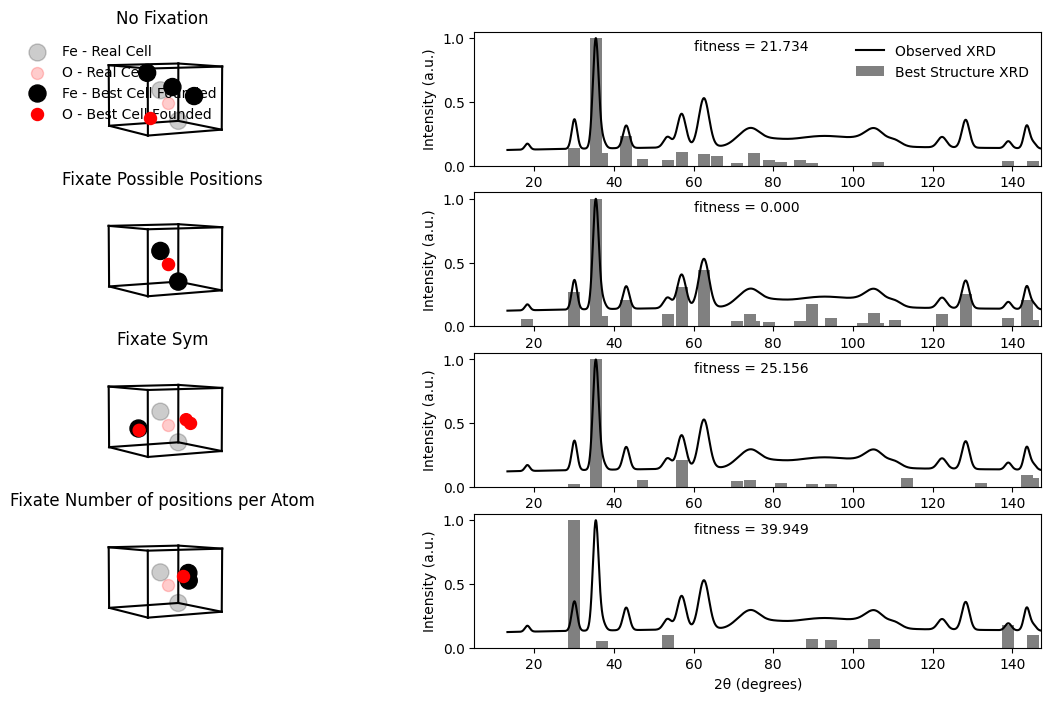

In [45]:
from matplotlib.gridspec import GridSpec


#Make as IF experimental pattern
thes = np.arange(min(observed_theta)-5,max(observed_theta)+5,0.01)
sum = 0
for i in range(len(observed_theta)):
    FWHM = 0.9 * lamb / (1 * np.cos(np.radians(observed_theta[i])))  # Scherrer
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma
    sum += U[i] * np.exp(-((thes - observed_theta[i])**2) / (2 * sigma**2))
sum = sum/max(sum)


#Define for plot
Z = {'Fe':30,'O':15}
colors = {'Fe':'black','O':'red'}
#begin plot
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(4, 2, width_ratios=[1, 1] , wspace=0.05,hspace = 0.2)
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(gs[0], projection='3d')  # 3D plot
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell_no.positions
Atoms = Best_cell_no.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
ax1.legend(frameon=False,loc='upper right')
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('No Fixation')
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(gs[1])  # 3D plot
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell_no.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_xlim(5,max(observed_theta)+2)
ax2.legend(loc ='upper right',frameon=False)
ax2.annotate(f'fitness = {compute_fitness(Best_cell_no,observed_theta,U,lamb,peak_tol=0.01):.3f}'
             ,xy=(60,0.9),xytext=(60,0.9))
#==================================================
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(gs[2], projection='3d')  # 3D plot
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell_pos.positions
Atoms = Best_cell_pos.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
#ax1.legend(frameon=False,loc='upper right')
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('Fixate Possible Positions')
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(gs[3])  # 3D plot
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell_pos.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_xlim(5,max(observed_theta)+2)
ax2.annotate(f'fitness = {compute_fitness(Best_cell_pos,observed_theta,U,lamb,peak_tol=0.01):.3f}'
             ,xy=(60,0.9),xytext=(60,0.9))
#==================================================
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(gs[4], projection='3d')  # 3D plot
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell_symm.positions
Atoms = Best_cell_symm.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
#ax1.legend(frameon=False,loc='upper right')
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('Fixate Sym')
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(gs[5])  # 3D plot
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell_symm.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_xlim(5,max(observed_theta)+2)
ax2.annotate(f'fitness = {compute_fitness(Best_cell_symm,observed_theta,U,lamb,peak_tol=0.01):.3f}'
             ,xy=(60,0.9),xytext=(60,0.9))

#==================================================
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(gs[6], projection='3d')  # 3D plot
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell_numb.positions
Atoms = Best_cell_numb.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
#ax1.legend(frameon=False,loc='upper right')
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('Fixate Number of positions per Atom')
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(gs[7])  # 3D plot
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell_numb.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_xlim(5,max(observed_theta)+2)
ax2.annotate(f'fitness = {compute_fitness(Best_cell_numb,observed_theta,U,lamb,peak_tol=0.01):.3f}'
             ,xy=(60,0.9),xytext=(60,0.9))
plt.tight_layout()
#plt.savefig('Figuras/Structure_Changing.svg')

---